# Koopman Operator Example 1

### References
- [Milan Korda, Igor Mezić, Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control, Automatica, 2018](https://www.sciencedirect.com/science/article/pii/S000510981830133X)
- [薄良彦, クープマン作用素による非線形システムの制御, 計測と制御, 2022](https://www.jstage.jst.go.jp/article/sicejl/61/2/61_133/_article/-char/ja/)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
color = {'orange': '#FF4B00', 'blue': '#005AFF', 'green': '#03AF7A', 'purple': '#990099'}

## Nonlinear System Dynamics
First, a nonlinear affine system is defined as a ground truth model
$$
\begin{align*}
\dot{\bm{x}} &= F(\bm{x}) + G(\bm{x})\bm{u} \\
\end{align*}
$$

Here we use single machine infinite bus system as an example,
$$
\begin{align}
&\text{system state }\bm{x}\in \mathbb{R}^2 \text{:} \quad \bm{x} = [x_1, x_2], \nonumber \\
&\text{control input }\bm{u}\in \mathbb{R} \text{:} \quad \bm{u} = [u_1], \nonumber \\
&\text{parameters: } D, B, P \in \mathbb{R}. \nonumber \\
\end{align}
$$

The state update rule is given by the following equation.
$$
\begin{equation}
\left\{
\begin{align}
\frac{\rm{d}}{\rm{d}t} x_1 &= x_2 \nonumber \\
\frac{\rm{d}}{\rm{d}t} x_2 &= -D x_2 - B \sin x_1 + P + u_1 \nonumber \\
\end{align}
\right. \nonumber
\end{equation}
$$

In [9]:
# define a nonlinear affine system (ground truth)
# this system is called as "single machine infinite bus system"
class NonlinearSystem:
    def __init__(self, x_init: np.ndarray):
        # initialize the state
        self.x = x_init # x is 2 dimensional: [x1, x2]

        # define the system parameters
        self.P = 0.07
        self.D = 0.05
        self.B = 0.7

    def step(self, u: np.ndarray, dt: float):
        # load control input and current state
        u1 = u[0] # u is 1 dimensional
        x1, x2 = self.x # x is 2 dimensional

        # update state
        x_dot = np.array([
            x2,
            -self.D * x2 - self.B * np.sin(x1) + self.P + u1
        ])
        self.x = self.x + x_dot * dt

    def get_state(self):
        return self.x.copy()

## Generate Training Data

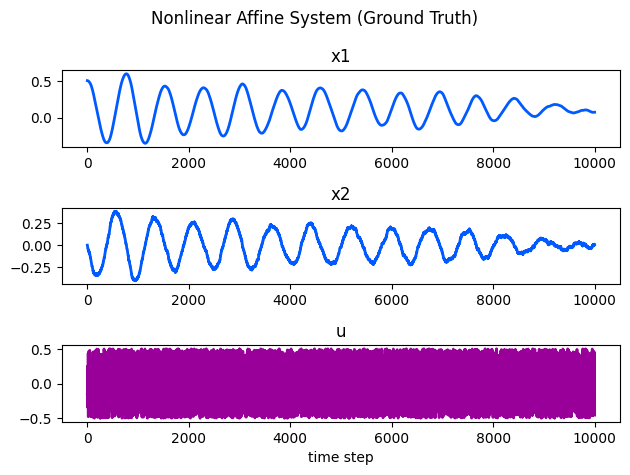

In [10]:
# try simulation with the ground truth system
dt = 0.01 # time step [s]
T = 100.0 # simulation time [s]
n_steps = int(T / dt)
x_init = np.array([0.5, 0.0])
system = NonlinearSystem(x_init)

# simulate the system
x_history = x_init # x log
u_history = np.array([]) # u log
for t in range(n_steps):
    # generate u as a random number between -0.1 to +0.1
    u = np.random.uniform(-0.5, +0.5, 1)
    system.step(u, dt)
    # stack system state vertically to x_history
    x_history = np.vstack((x_history, system.get_state()))
    if t == 0:
        u_history = u
    else:
        u_history = np.vstack((u_history, u))

# plot the results, top figure is x1, middle figure is x2, bottom figure is u
ax, fig = plt.subplots(3, 1)
# add suptitle to the figure
plt.suptitle('Nonlinear Affine System (Ground Truth)')
fig[0].set_title('x1')
fig[0].plot(x_history[:, 0], lw=2, label='x1', color=color['blue'])
fig[1].set_title('x2')
fig[1].plot(x_history[:, 1], lw=2, label='x2', color=color['blue'])
fig[2].set_title('u')
fig[2].plot(u_history, lw=2, label='u', color=color['purple'])
fig[2].set_xlabel('time step')
plt.tight_layout()
plt.savefig('ex1_training.png', dpi=300)
plt.show()

## Define Koopman Eigenfunctions Manually

Here we define the koopman eigenfunctions manually. The number of eigenfunctions is $N$.
$$
\begin{align*}
    \{\psi_i : i = 1, \ldots, N\} &= 
    \{ x_1, x_2, \sin(x_1), \cos(x_1), x_2 \cos(x_1), x_2 \sin(x_1) \}
\end{align*}
$$

Then, original state $\bm{x}$ can be transformed to the feature space $\bm{z}$ by the eigenfunctions,
$$
\begin{align*}
    \bm{z} &= [\psi_1(\bm{x}), \ldots, \psi_N(\bm{x})]^T, \\
              &= \bm{\psi}(\bm{x}).
\end{align*}
$$

In [11]:
def psi(x: np.ndarray):
    # define koopman eigenfunctions
    return np.array([x[0], x[1], np.sin(x[0]), np.cos(x[0]), x[1]*np.cos(x[0]), x[1]*np.sin(x[0])]).T

## Fit Linear Transformation Matrices: A, B, C

Use x_history and u_history generated above as training data.

In [12]:
# Prepare Training Data
# X = [x1, x2, ..., xk]
X = x_history.T
print("X shape:", X.shape)
# X_lift = [psi(x1), psi(x2), ..., psi(xk)]
X_lift = psi(X).T
print("X_lift shape:", X_lift.shape)
# Y = [x2, x3, ..., xk, xk]
Y = np.append(X[:, 1:], X[:, -1:], axis=1)
print("Y shape:", Y.shape)
# Y_lift = [psi(x2), psi(x3), ..., psi(xk), psi(xk)]
Y_lift = psi(Y).T
print("Y_lift shape:", Y_lift.shape)
# U = [u1, u2, ..., uk]
U = u_history.T
u_last = U[:, -1].reshape(U.shape[0], 1)
U = np.append(U, u_last, axis=1) # set the last input as the same as the previous one
print("U shape:", U.shape)

# check the size of the matrices
size_k = X.shape[1]
size_N = X_lift.shape[0]
size_m = U.shape[0]
print("size_k:", size_k)
print("size_N:", size_N)
print("size_m:", size_m)

# fit A, B
X_lift_U = np.vstack((X_lift, U))
AB = Y_lift @ np.linalg.pinv(X_lift_U)
A = AB[:, :size_N]
print("Fit A Matrix, A shape is", A.shape)
B = AB[:, size_N:]
print("Fit B Matrix, B shape is", B.shape)

# fit C
C = X @ np.linalg.pinv(X_lift)
print("Fit C Matrix, C shape is", C.shape)

X shape: (2, 10001)
X_lift shape: (6, 10001)
Y shape: (2, 10001)
Y_lift shape: (6, 10001)
U shape: (1, 10001)
size_k: 10001
size_N: 6
size_m: 1
Fit A Matrix, A shape is (6, 6)
Fit B Matrix, B shape is (6, 1)
Fit C Matrix, C shape is (2, 6)


## Approximated System Dynamics

$$
\begin{align*}
    \bm{z}[k+1] &= A\bm{z}[k] + B\bm{u}[k] \\
    \hat{\bm{x}}[k] &= C\bm{z}[k]
\end{align*}
$$

In [13]:
# define a nonlinear affine system (ground truth)
class ApproximatedSystem:
    def __init__(self, x_init: np.ndarray, A: np.ndarray, B: np.ndarray, C: np.ndarray, psi: callable):
        # initialize the state
        self.x = x_init # x is 2 dimensional: [x1, x2]

        # define the system parameters
        self.A = A
        self.B = B
        self.C = C
        self.psi = psi

        # get initial state in the lifted space
        self.z = self.psi(self.x) # z is the latent state in the lifted linear space

    def step(self, u: np.ndarray):
        # update state
        self.z = self.A @ self.z + self.B @ u
        self.x = self.C @ self.z

    def get_state(self):
        return self.x.copy()

## Compare the Approximated System with the Original System

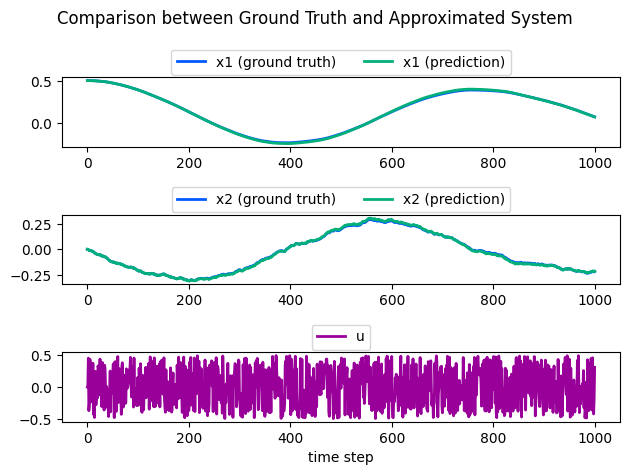

In [14]:
# try simulation with both ground truth and learned system
dt = 0.01 # time step [s]
T = 10.0 # simulation time [s]
n_steps = int(T / dt)
x_init = np.array([0.5, 0.0])
ground_truth_system = NonlinearSystem(x_init)
approximated_system = ApproximatedSystem(x_init, A, B, C, psi)

# simulate the system
x_gt_history = x_init # x log of ground truth system
x_ap_history = x_init # x log of approximated system
u_history = np.array([0.0]) # u log
for t in range(n_steps):
    # generate u as a random number between -0.1 to +0.1
    u = np.random.uniform(-0.5, 0.5, 1)

    # update state of both systems
    ground_truth_system.step(u, dt)
    approximated_system.step(u)

    # save system state and control input
    x_gt_history = np.vstack((x_gt_history, ground_truth_system.get_state()))
    x_ap_history = np.vstack((x_ap_history, approximated_system.get_state()))
    u_history = np.vstack((u_history, u))

# plot the results, top figure is x1, middle figure is x2, bottom figure is u
ax, fig = plt.subplots(3, 1)
# add suptitle to the figure
plt.suptitle('Comparison between Ground Truth and Approximated System')
# x1
fig[0].plot(x_gt_history[:, 0], lw=2, label='x1 (ground truth)', color=color['blue'])
fig[0].plot(x_ap_history[:, 0], lw=2, label='x1 (prediction)', color=color['green'])
fig[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# x2
fig[1].plot(x_gt_history[:, 1], lw=2, label='x2 (ground truth)', color=color['blue'])
fig[1].plot(x_ap_history[:, 1], lw=2, label='x2 (prediction)', color=color['green'])
fig[1].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# u
fig[2].plot(u_history, lw=2, label='u', color=color['purple'])
fig[2].set_xlabel('time step')
fig[2].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# adjust layout and show figure
plt.tight_layout()
plt.savefig('ex1_evaluation.png', dpi=300)
plt.show()